In [1]:
# Import Libraries
import time
import random
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [3]:
df = pd.read_csv("indonesian_conversation_data.csv", low_memory = False, encoding='utf8')
df.head()

,Pertanyaan,Jawaban,Kategori
0,Apa yang menyebabkan depresi?,Depresi dapat disebabkan oleh kombinasi faktor...,Apa Depresi
1,Apa gejala umum dari depresi?,"Gejala umum depresi meliputi perasaan sedih, k...",Apa Depresi
2,Bagaimana cara mengatasi depresi?,Cara mengatasi depresi dapat meliputi terapi p...,Bagaimana Depresi
3,Apakah depresi bisa disembuhkan?,Depresi dapat disembuhkan dengan pengobatan ya...,Apakah Depresi
4,Apakah ada faktor risiko untuk mengalami depresi?,Ada beberapa faktor risiko yang dapat meningka...,Apakah Depresi


In [4]:
data = df[['Pertanyaan', 'Kategori']]
data.head()

,Pertanyaan,Kategori
0,Apa yang menyebabkan depresi?,Apa Depresi
1,Apa gejala umum dari depresi?,Apa Depresi
2,Bagaimana cara mengatasi depresi?,Bagaimana Depresi
3,Apakah depresi bisa disembuhkan?,Apakah Depresi
4,Apakah ada faktor risiko untuk mengalami depresi?,Apakah Depresi


In [5]:
# Removing Punctuations (Menghilangkan Punktuasi)
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: ''.join([ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation]))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r'\n', ' ', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r'\(', '', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r'\)', '', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r',', '', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r'-', '', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r'/', '', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r'/', '', wrd))
data.loc[:, 'Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: re.sub(r"[^\w]", ' ', wrd))

<ipython-input-5-1a5ebe9b403c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
<ipython-input-5-1a5ebe9b403c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pertanyaan'] = data['Pertanyaan'].apply(lambda wrd: ''.join(wrd))
<ipython-input-5-1a5ebe9b403c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

In [6]:
kata_index = {}
for pattern in data['Pertanyaan']:
      kata = pattern.lower().split()
      for w in kata:
            if w not in kata_index:
                  kata_index[w] = len(kata_index) + 1

In [7]:
kata_index

{'apa': 1,
 'yang': 2,
 'menyebabkan': 3,
 'depresi': 4,
 'gejala': 5,
 'umum': 6,
 'dari': 7,
 'bagaimana': 8,
 'cara': 9,
 'mengatasi': 10,
 'apakah': 11,
 'bisa': 12,
 'disembuhkan': 13,
 'ada': 14,
 'faktor': 15,
 'risiko': 16,
 'untuk': 17,
 'mengalami': 18,
 'mengenali': 19,
 'seseorang': 20,
 'menderita': 21,
 'sebaiknya': 22,
 'dilakukan': 23,
 'jika': 24,
 'terdiagnosis': 25,
 'menyerang': 26,
 'siapa': 27,
 'saja': 28,
 'mempengaruhi': 29,
 'kualitas': 30,
 'hidup': 31,
 'merawat': 32,
 'diri': 33,
 'sendiri': 34,
 'ketika': 35,
 'jenisjenis': 36,
 'berbeda': 37,
 'dengan': 38,
 'suasana': 39,
 'hati': 40,
 'buruk': 41,
 'bisakah': 42,
 'terjadi': 43,
 'tanpa': 44,
 'alasan': 45,
 'jelas': 46,
 'terapi': 47,
 'dapat': 48,
 'membantu': 49,
 'gangguan': 50,
 'tidur': 51,
 'olahraga': 52,
 'mengurangi': 53,
 'obat': 54,
 'efektif': 55,
 'mengobati': 56,
 'mendukung': 57,
 'berhubungan': 58,
 'kecemasan': 59,
 'tidak': 60,
 'saat': 61,
 'mendampingi': 62,
 'terdapat': 63,
 'perbe

In [8]:
sequences = []
for sentence in data['Pertanyaan']:
    words = sentence.lower().split()  # Mengubah ke huruf kecil dan memecah kalimat menjadi kata-kata
    sequence = [kata_index[word] for word in words]  # Mengubah setiap kata menjadi angka berdasarkan kamus
    sequences.append(sequence)

In [9]:
sequences

[[1, 2, 3, 4],
 [1, 5, 6, 7, 4],
 [8, 9, 10, 4],
 [11, 4, 12, 13],
 [11, 14, 15, 16, 17, 18, 4],
 [8, 9, 19, 20, 2, 21, 4],
 [1, 2, 22, 23, 24, 20, 25, 4],
 [11, 4, 12, 26, 27, 28],
 [11, 4, 12, 29, 30, 31, 20],
 [8, 9, 32, 33, 34, 35, 18, 4],
 [1, 28, 36, 4, 2, 6],
 [11, 4, 37, 38, 39, 40, 2, 41],
 [42, 4, 43, 44, 45, 2, 46],
 [11, 47, 48, 49, 10, 4],
 [11, 4, 48, 3, 50, 51],
 [11, 52, 12, 49, 53, 5, 4],
 [11, 4, 29, 30, 51],
 [11, 14, 54, 2, 55, 17, 56, 4],
 [8, 9, 57, 20, 2, 18, 4],
 [11, 4, 58, 38, 59],
 [1, 2, 22, 60, 23, 61, 62, 20, 38, 4],
 [11, 63, 64, 65, 4, 66, 67, 68, 69],
 [8, 9, 70, 11, 20, 71, 72, 73, 74, 18, 4],
 [11, 75, 48, 76, 77, 4],
 [11, 47, 78, 55, 79, 56, 4],
 [11, 50, 51, 48, 76, 5, 4],
 [8, 9, 80, 20, 2, 81, 18, 4],
 [11, 82, 12, 21, 4],
 [11, 4, 48, 29, 83, 20],
 [8, 9, 84, 85, 86, 17, 10, 4],
 [11, 63, 87, 2, 48, 49, 53, 5, 4],
 [8, 9, 88, 89, 90, 61, 18, 4],
 [11, 4, 48, 3, 50, 91],
 [8, 9, 57, 33, 34, 61, 92, 4],
 [11, 4, 58, 38, 93, 94, 91],
 [8, 9, 88, 95

In [10]:
# Menentukan panjang maksimum urutan angka
max_length = max(len(sequence) for sequence in sequences)

# Melakukan padding pada setiap urutan angka
padded_sequences = []
for sequence in sequences:
    padded_sequence = sequence + [0] * (max_length - len(sequence))
    padded_sequences.append(padded_sequence)

# Menyimpan hasil padded dalam variabel
padded_sequences_variable = padded_sequences

# Menampilkan urutan angka yang telah dipad
for padded_sequence in padded_sequences_variable:
    print(padded_sequence)

[1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 5, 6, 7, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[8, 9, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 4, 12, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 14, 15, 16, 17, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[8, 9, 19, 20, 2, 21, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 22, 23, 24, 20, 25, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 4, 12, 26, 27, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 4, 12, 29, 30, 31, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[8, 9, 32, 33, 34, 35, 18, 4, 0, 0, 0, 0, 0,

In [11]:
train = padded_sequences_variable

In [12]:
x_train = np.array(train)

In [13]:
panjang_input = x_train.shape[1]
print(panjang_input)

34


In [14]:
labels = data['Kategori']
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
y_train1 = labels.map(label_mapping)
y_train = y_train1.to_numpy()
y_train

array([  0,   0,   1, ..., 214, 214, 214])

In [15]:
label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}

In [16]:
label_mapping_inverse

{0: 'Apa Depresi',
 1: 'Bagaimana Depresi',
 2: 'Apakah Depresi',
 3: 'Bisakah Depresi',
 4: 'Apakah Stres',
 5: 'Bagaimana Cemas',
 6: 'Apakah Kesehatan Mental',
 7: 'Bagaimana Sedih',
 8: 'Bagaimana Keseimbangan',
 9: 'Bagaimana Stres',
 10: 'Bagaimana Kepercayaan Diri',
 11: 'Apa Kepercayaan Diri',
 12: 'Apa Cemas',
 13: 'Bagaimana Putus Asa',
 14: 'Bagaimana Kesehatan Mental',
 15: 'Apa Overthinking',
 16: 'Bagaimana Overthinking',
 17: 'Apakah Overthinking',
 18: 'Apa Sedih',
 19: 'Apakah Sedih',
 20: 'Apakah Cemas',
 21: 'Mengapa Menangis',
 22: 'Apakah Menangis',
 23: 'Bagaimana Menangis',
 24: 'Apa Kecewa',
 25: 'Bagaimana Kecewa',
 26: 'Apakah Kecewa',
 27: 'Apa Insecure',
 28: 'Bagaimana Insecure',
 29: 'Apakah Insecure',
 30: 'Apa Toxic',
 31: 'Bagaimana Toxic',
 32: 'Apakah Toxic',
 33: 'Apa Inner Child',
 34: 'Bagaimana Inner Child',
 35: 'Apakah Inner Child',
 36: 'Apa Mood',
 37: 'Bagaimana Mood',
 38: 'Apakah Mood',
 39: 'Apa Frustasi',
 40: 'Bagaimana Frustasi',
 41: '

In [17]:
# define vocabulary
vocabulary = len(kata_index)
print("Jumlah vocabulary data pertanyaan : ", vocabulary)

# output length
tag = np.unique(data['Kategori'])
panjang_output = len(tag)
print("Jumlah kelas unik: ", panjang_output)
print("Kelas unik: ", tag[0:5])

Jumlah vocabulary data pertanyaan :  2165
Jumlah kelas unik:  215
Kelas unik:  ['Apa Anxiety' 'Apa Autisme' 'Apa Bersyukur' 'Apa Bipolar' 'Apa Cemas']


In [18]:
from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [19]:
from keras import regularizers
i = Input(shape=(panjang_input,))
embedding_i = Embedding(vocabulary+1, 15)(i)
lstm_i = LSTM(15, return_sequences=True)(embedding_i)  # Regularisasi L2 dengan lambda=0.01
flatten_i = Flatten()(lstm_i)
output_i = Dense(panjang_output, activation="softmax")(flatten_i)  # Regularisasi L2 dengan lambda=0.01


model = Model(inputs=i, outputs=output_i)
# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 embedding (Embedding)       (None, 34, 15)            32490     
                                                                 
 lstm (LSTM)                 (None, 34, 15)            1860      
                                                                 
 flatten (Flatten)           (None, 510)               0         
                                                                 
 dense (Dense)               (None, 215)               109865    
                                                                 
Total params: 144,215
Trainable params: 144,215
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_model = model.fit(xtr, ytr, epochs=100, validation_data=(xte,yte))

Epoch 1/100
119/119 [==============================] - 6s 30ms/step - loss: 4.8691 - accuracy: 0.0364 - val_loss: 4.5868 - val_accuracy: 0.0443
Epoch 2/100
119/119 [==============================] - 3s 24ms/step - loss: 3.7395 - accuracy: 0.1584 - val_loss: 3.2540 - val_accuracy: 0.2236
Epoch 3/100
119/119 [==============================] - 3s 28ms/step - loss: 2.7921 - accuracy: 0.3035 - val_loss: 2.6492 - val_accuracy: 0.3449
Epoch 4/100
119/119 [==============================] - 3s 26ms/step - loss: 2.2268 - accuracy: 0.4431 - val_loss: 2.2870 - val_accuracy: 0.4420
Epoch 5/100
119/119 [==============================] - 3s 21ms/step - loss: 1.8117 - accuracy: 0.5342 - val_loss: 2.0336 - val_accuracy: 0.4958
Epoch 6/100
119/119 [==============================] - 2s 21ms/step - loss: 1.4976 - accuracy: 0.6049 - val_loss: 1.9535 - val_accuracy: 0.5422
Epoch 7/100
119/119 [==============================] - 3s 21ms/step - loss: 1.2571 - accuracy: 0.6743 - val_loss: 1.7830 - val_accuracy:

In [22]:
loss, accuracy = model.evaluate(xte, yte)

# Menampilkan hasil evaluasi
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

30/30 [==============================] - 0s 8ms/step - loss: 2.3496 - accuracy: 0.7078
Loss: 2.35
Accuracy: 70.78%


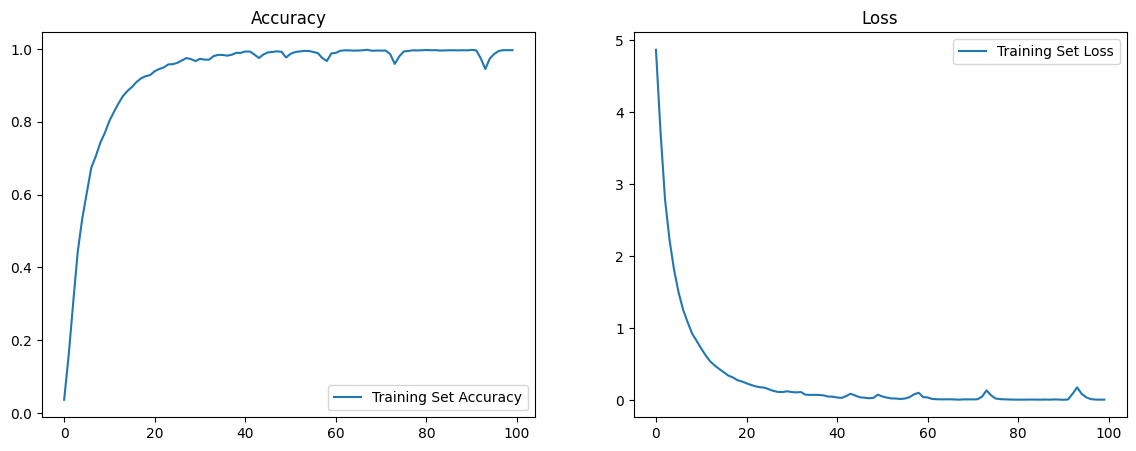

In [23]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_model.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_model.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [24]:
import h5py
model.save('model.h5')